In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [2]:
# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Creating transform for our images
data_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True)
])

In [4]:
import os

NUM_WORKERS = 2
BATCH_SIZE = 32
LATENT_SIZE = 128
EPOCHS = 5
LR = 0.0002
BETAS = (0.5, 0.999)

In [5]:
# Importing the dataset and creating dataloader.
train_dataset = datasets.FashionMNIST(root='./', train=True, transform=data_transform, download=True)
test_dataset = datasets.FashionMNIST(root='./', train=False, transform=data_transform, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

100%|██████████| 26421880/26421880 [00:01<00:00, 15202327.78it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269128.09it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4957822.44it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3200752.59it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [6]:
image, label = next(iter(train_dataloader))
image.shape, label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Visualizing a batch of random images from dataloader.

In [7]:
class_names = train_dataset.classes
num_classes = len(class_names)
class_names, num_classes

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

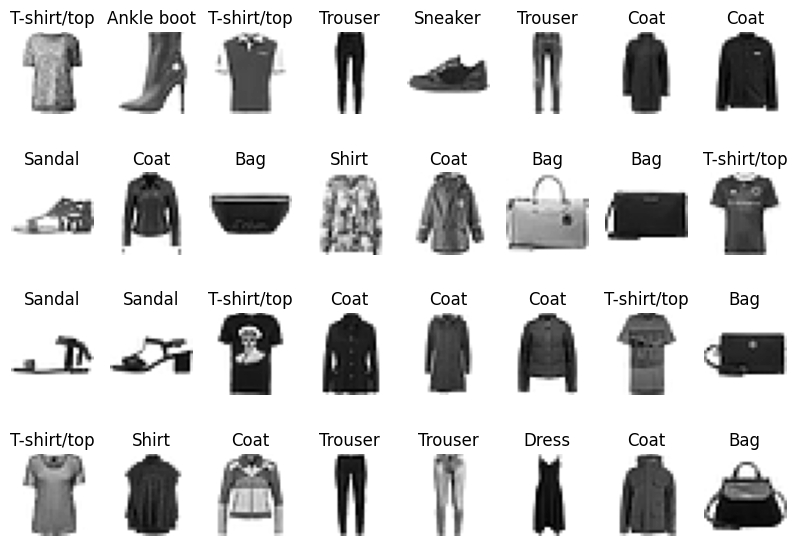

In [8]:
import matplotlib.pyplot as plt

image, label = next(iter(train_dataloader))

plt.figure(figsize=(10,7))
for i in range(BATCH_SIZE):
 plt.subplot(4, 8, 1 + i)
 img = image[i].permute(1, 2, 0)
 plt.title(f'{class_names[label[i].item()]}')
 plt.imshow(img, cmap='gray_r')
 plt.axis(False)
plt.show()

# How will we make the DCGAN conditional ?

### We first need to encode our labels.

There are 2 methods for encoding the label data -
- We can either use one hot encoding to encode the data. (`torch.nn.functional.one_hot()`). It's not the recommended way since we may have a lot of labels sometimes, for which we have to create huge one hot vectors that are sparse. This is not optimal for memory and computation.
- We can use the embedding layer from PyTorch (`nn.Embedding()`) and make it the same as our image size (28x28) and then use that layer as an additional dimension of the image.

The better method is using the embedding layer so we're going to use that in our model.

To make the GAN conditional all we need do for the generator is feed the class labels into the network. These are concatenated with the latent embedding before going through the transposed convolutional layers to generate an image.

For the critic, we can concatenate the class label with the flattened CNN features or we can add the label embedding to the image as an extra dimension so the fully connected layers can use that information to distinguish between the classes.

## Creating the Discriminator

In [9]:
# Creating the discriminator
class Discriminator(nn.Module):

  def __init__(self, in_channels, num_classes, batch_size):
    super().__init__()

    self.batch_size = batch_size

    # We want to create the embedding as an extra image channel and pass it into the model.
    self.label_embed = nn.Embedding(num_classes, 28*28)

    self.conv_layers = nn.Sequential(
        # Input --> BATCH_SIZE, 2, 28, 28
        nn.Conv2d(in_channels + 1, 32, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        # Output Feature Maps --> BATCH_SIZE, 32, 14, 14

        nn.Conv2d(32, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # Output Feature Maps --> BATCH_SIZE, 64, 7, 7

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # Output Feature Maps --> BATCH_SIZE, 128, 3, 3

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        # nn.BatchNorm2d(256),  Didn't apply BatchNorm2d because it requres atleast (2, 2) tensor to apply normalization.
        nn.LeakyReLU(0.2, inplace=True)
        # Output Feature Maps --> BATCH_SIZE, 256, 1, 1
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*1*1, 1),
        nn.Sigmoid()
    )

  def forward(self, x, label):
    # Passing class label to embedding channel. Want shape as --> [batch_size, 1, 28, 28]
    embed_channel = self.label_embed(label).view(self.batch_size, 1, 28, 28)
    # Adding the embedding as additional channel.
    x = torch.cat([x, embed_channel], dim=1)
    return self.classifier(self.conv_layers(x))

In [10]:
image, label = next(iter(train_dataloader))
image = image.to(device)
label = label.to(device)
discriminator = Discriminator(1, num_classes, BATCH_SIZE).to(device)
preds = discriminator(image, label)
preds

tensor([[0.5058],
        [0.5304],
        [0.5487],
        [0.5514],
        [0.5745],
        [0.5057],
        [0.4969],
        [0.5530],
        [0.5457],
        [0.5412],
        [0.5274],
        [0.5634],
        [0.5522],
        [0.5537],
        [0.5392],
        [0.5197],
        [0.5793],
        [0.5309],
        [0.5597],
        [0.5406],
        [0.5333],
        [0.5706],
        [0.4786],
        [0.5341],
        [0.5683],
        [0.5521],
        [0.5398],
        [0.5328],
        [0.5529],
        [0.5700],
        [0.5332],
        [0.5150]], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Creating the Generator

For transpose convolutions on square tensors, the formula is -

H_out =(H_in - 1) * stride - 2 * padding + dilation * (kernel_size-1) + output_padding + 1

dilation is 1 by default, output padding is 0 by default

`H_out = (H_in-1) * stride + (kernel_size-1) - 2 * padding + 1`

In [11]:
class Generator(nn.Module):

  def __init__(self, z_dim, num_classes, batch_size):
    super().__init__()

    self.batch_size = batch_size

    # We want to pass the latent vector + the number of classes as input to generator.
    self.embed_layer = nn.Embedding(num_classes, num_classes) # 10 inputs to 10 outputs.

    self.trans_conv_layers = nn.Sequential(
        # Input is latent dimension vector of size --> z_dim + num_classes, 1, 1
        nn.ConvTranspose2d(z_dim + num_classes, 256, 4, 2, 1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        # Output Size = 256, 2, 2

        nn.ConvTranspose2d(256, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        # Output Size = 128, 4, 4

        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        # Output Size = 64, 8, 8

        nn.ConvTranspose2d(64, 32, 4, 2, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(True),
        # Output Size = 32, 16, 16

        nn.ConvTranspose2d(32, 1, 4, 2, 3),
        nn.Tanh()
        # Output Size = 1, 28, 28
    )

  # We send the label as 2nd input to generate images targeting that specific label.
  def forward(self, noise, label):
    embed_tensor = self.embed_layer(label)  # Shape --> 32, 10. Want --> 32, 10, 1, 1.
    embed_tensor = embed_tensor.unsqueeze(2).unsqueeze(3)  # Add dimensions to match noise
    noise = torch.cat((noise, embed_tensor), dim=1)  # Concatenate along the channel dimension
    return self.trans_conv_layers(noise)

In [12]:
generator = Generator(LATENT_SIZE, num_classes, BATCH_SIZE).to(device)
noise = torch.rand(size=[BATCH_SIZE, LATENT_SIZE, 1, 1]).to(device)
# Just using a random label here. Just wanted to check if model can generate correct shape or not.
output = generator(noise, label)
output.shape

torch.Size([32, 1, 28, 28])

# Write training and testing loop

In [13]:
# Training the discriminator.
def train_discriminator(discriminator: nn.Module,
                        generator: nn.Module,
                        d_optim: torch.optim.Optimizer,
                        real_images: torch.Tensor,
                        labels: torch.Tensor,
                        batch_size: int,
                        latent_size: int,
                        loss_fn: nn.Module = nn.BCELoss(),
                        device: torch.device = 'cpu'):

  # Setting appropriate modes for models.
  # discriminator.train()
  # generator.eval()

  # Make predictions
  real_preds = discriminator(real_images, labels)
  real_targets = torch.ones(size=[real_images.size(0), 1]).to(device)
  real_loss = loss_fn(real_preds, real_targets)

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
  fake_images = generator(latent, labels)

  # Pass fake images through discriminator
  fake_preds = discriminator(fake_images, labels)
  fake_targets = torch.zeros(size=[fake_images.size(0), 1]).to(device)
  fake_loss = loss_fn(fake_preds, fake_targets)

  # Update discriminator weights
  loss = real_loss + fake_loss
  d_optim.zero_grad()
  loss.backward()
  d_optim.step()

  return loss.item()

In [14]:
# Training the generator.
def train_generator(discriminator: nn.Module,
                    generator: nn.Module,
                    g_optim: torch.optim.Optimizer,
                    labels: torch.Tensor,
                    batch_size: int,
                    latent_size: int,
                    loss_fn: nn.Module = nn.BCELoss(),
                    device: torch.device = device):

  # Setting appropriate states for models.
  # discriminator.eval()
  # generator.train()

  # Generate fake images.
  latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
  fake_images = generator(latent, labels)

  # Pass the images to discriminator.
  fake_preds = discriminator(fake_images, labels)
  target = torch.ones([fake_images.size(0), 1]).to(device)

  # Calculate the loss.
  loss = loss_fn(fake_preds, target)

  # Set gradients to zero
  g_optim.zero_grad()

  # Backprop
  loss.backward()
  g_optim.step()

  return loss.item()

In [15]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [35]:
# Creating the generator and discriminator.
generator = Generator(LATENT_SIZE, num_classes, BATCH_SIZE).to(device)
discriminator = Discriminator(1, num_classes, BATCH_SIZE).to(device)

In [37]:
from torchvision.utils import make_grid
from tqdm.auto import tqdm
def train(epochs, lr, betas, start_idx=1, device: torch.device = device):

  d_losses = []
  g_losses = []
  images = []

  # Creating optimizers and loss function.
  g_optim = torch.optim.Adam(generator.parameters(),
                            lr=LR, betas=betas)
  d_optim = torch.optim.Adam(discriminator.parameters(),
                            lr=LR, betas=betas)

  loss_fn = nn.BCELoss()

  for epoch in range(epochs):

    d_loss, g_loss = 0, 0

    for batch, (real_images, labels) in enumerate(tqdm(train_dataloader)):

      # Moving data to target device
      real_images = real_images.to(device)
      labels = labels.to(device)

      # Train discriminator
      d_loss += train_discriminator(discriminator, generator, d_optim, real_images, labels, BATCH_SIZE, LATENT_SIZE, loss_fn, device)

      # Train generator
      g_loss += train_generator(discriminator, generator, g_optim, labels, BATCH_SIZE, LATENT_SIZE, loss_fn, device)

    # Calculating the average loss per batch
    d_loss /= len(train_dataloader)
    g_loss /= len(train_dataloader)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # Print info
    print("Epoch: [{}/{}] | Discriminator Loss: {:.4f} | Generator Loss: {:.4f}".format(
        epoch+1, epochs, d_loss, g_loss
    ))

  return d_losses, g_losses

In [38]:
d_losses, g_losses = train(EPOCHS, LR, BETAS)

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: [1/5] | Discriminator Loss: 1.2584 | Generator Loss: 1.1375


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: [2/5] | Discriminator Loss: 1.2462 | Generator Loss: 1.0672


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: [3/5] | Discriminator Loss: 1.1826 | Generator Loss: 1.1496


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: [4/5] | Discriminator Loss: 1.0932 | Generator Loss: 1.2947


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: [5/5] | Discriminator Loss: 0.9198 | Generator Loss: 1.6530


In [39]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

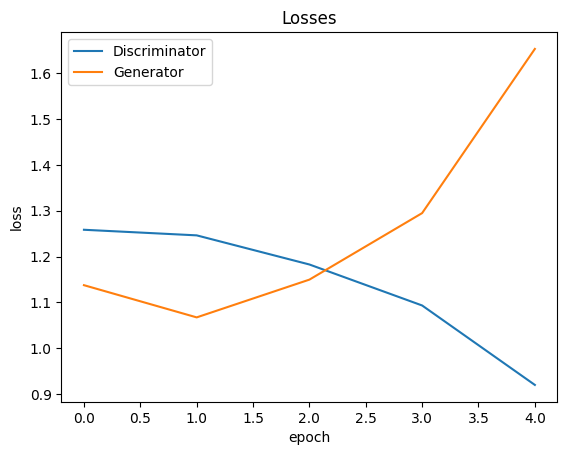

In [42]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [53]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [55]:
def generate_image(generator, latent_size, class_index):
  noise = torch.rand(size=[1, latent_size, 1, 1]).to(device)
  label = torch.Tensor([class_index]).type(torch.IntTensor).to(device)
  output = generator(noise, label)
  output = output.squeeze(dim=0).to('cpu')
  output = output.detach()
  output = output.permute(1, 2, 0)
  plt.imshow(output, cmap='gray')

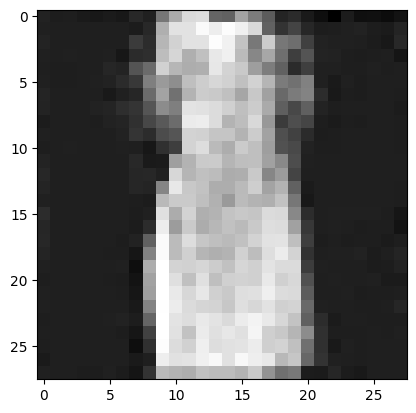

In [56]:
generate_image(generator, LATENT_SIZE, 3)